# BUSINESS OBJECTIVE : Loan default prediction with machine learning algorithms.

#### 1. Import Libraries

In [35]:
#Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import svm
plt.style.use('ggplot')

In [2]:
import os
os.listdir()

['.ipynb_checkpoints',
 'bank-data-loan-default',
 'bank-data-loan-default.zip',
 'LoanDefault-Prediction-master',
 'LoanDefault-Prediction-master.zip',
 'LoanDefaultPrediction.ipynb',
 'Untitled.ipynb',
 'Untitled1.ipynb']

#### 2. Import Data

Credit card


- card_id	record identifier	
- disp_id	disposition to an account	
- type	type of card	possible values are "junior", "classic", "gold"
- issued	issue date	in the form YYMMDD


In [3]:
card = pd.read_csv("bank-data-loan-default/card.asc",sep=";",delimiter=None,header="infer",names=None,low_memory=False)

In [4]:
card.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [5]:
card["type"] = pd.get_dummies(card["type"]) 

In [6]:
card.issued = card.issued.str.strip("00:00:00")
card.issued = card.issued.astype("int") # To convert to date format using pd_to_Datetime, convert the column to int type first.

In [7]:
card.issued = card.issued.apply(lambda x: pd.to_datetime(x, format="%y%m%d"))

In [8]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
card_id    892 non-null int64
disp_id    892 non-null int64
type       892 non-null uint8
issued     892 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), uint8(1)
memory usage: 21.9 KB


Account:
    
- account_id	identification of the account
- district_id	location of the branch	
- date	date of creating of the account	in the form YYMMDD
- frequency	frequency of issuance of statements	"POPLATEK MESICNE" stands for monthly issuance, "POPLATEK TYDNE" stands for weekly issuance, "POPLATEK PO OBRATU" stands for issuance after transaction


In [9]:
account = pd.read_csv("bank-data-loan-default/account.asc",sep=";",delimiter=None,header="infer",names=None,low_memory=False)

In [10]:
account.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102


In [11]:
account.date = account.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))

Disposition

- disp_id	record identifier	
- client_id	identification of a client	
- account_id	identification of an account	
- type	type of disposition (owner/user)	only owner can issue permanent orders and ask for a loan


In [12]:
disp = pd.read_csv("bank-data-loan-default/disp.asc",sep=";",delimiter=None,header="infer",names=None,low_memory=False)

In [13]:
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [14]:
#only owner can issue permanent orders and ask for a loan
disp = disp[disp.type == "OWNER"]
disp.rename(columns={"type": "type_disp"}, inplace=True)

Client

- client_id	record identifier	
- birth number	identification of client	the number is in the form YYMMDD for men, the number is in the form YYMM+50DD for women, where YYMMDD is the date of birth
- district_id	address of the client	


In [15]:
client = pd.read_csv("bank-data-loan-default/client.asc",sep=";",delimiter=None,header="infer",names=None,low_memory=False)

In [16]:
client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [17]:
client["month"] = client.birth_number.apply(lambda x: x // 100 % 100, convert_dtype=True, args=())
client["year"] = client.birth_number.apply(lambda x: x // 100 // 100, convert_dtype=True, args=())

In [18]:
client["age"] = 99 - client.year
client["sex"] = client.month.apply(lambda x: (x - 50) < 0, convert_dtype=True, args=())
client.sex = client.sex.astype(int)  # 0 for female, 1 for male
client.drop(["birth_number", "month", "year"], axis=1, inplace=True)

District

- A1 = district_id	district code
- A2	district name
- A3	region
- A4	no. of inhabitants
- A5	no. of municipalities with inhabitants < 499
- A6	no. of municipalities with inhabitants 500-1999
- A7	no. of municipalities with inhabitants 2000-9999
- A8	no. of municipalities with inhabitants >10000
- A9	no. of cities
- A10	ratio of urban inhabitants
- A11	average salary
- A12	unemploymant rate '95
- A13	unemploymant rate '96
- A14	no. of enterpreneurs per 1000 inhabitants
- A15	no. of commited crimes '95
- A16	no. of commited crimes '96


In [19]:
district = pd.read_csv("bank-data-loan-default/district.asc",sep=";",delimiter=None,header="infer",names=None,low_memory=False)

In [20]:
district.drop(["A2", "A3"], axis=1, inplace=True)

In [21]:
district.head()

,A1,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [22]:
order = pd.read_csv("bank-data-loan-default/order.asc",sep=";",delimiter=None,header="infer",names=None,low_memory=False)

In [23]:
order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


In [24]:
order.drop(["bank_to", "account_to", "order_id"], axis=1, inplace=True)
order.k_symbol.fillna("No_symbol")
order.k_symbol = order.k_symbol.str.replace(" ", "No_symbol")
order = order.groupby(["account_id", "k_symbol"]).mean().unstack()

In [25]:
order = order.fillna(0)
order.columns = order.columns.droplevel()
order.reset_index(level="account_id", col_level=1, inplace=True)
order.rename_axis("", axis="columns", inplace=True)
order.rename(
    index=None,
    columns={
        "LEASING": "order_amount_LEASING",
        "No_symbol": "order_amount_No_symbol",
        "POJISTNE": "order_amount_POJISTNE",
        "SIPO": "order_amount_SIPO",
        "UVER": "order_amount_UVER",
    },
    inplace=True,
)

In [26]:
order.head()

,account_id,order_amount_LEASING,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER
0,1,0.0,0.0,0.0,2452.0,0.0
1,2,0.0,0.0,0.0,7266.0,3372.7
2,3,0.0,327.0,3539.0,1135.0,0.0
3,4,0.0,0.0,0.0,1681.5,0.0
4,5,0.0,0.0,0.0,2668.0,0.0


Loan

- loan_id	record identifier	
- account_id	identification of the account	
- date	date when the loan was granted	in the form YYMMDD
- amount	amount of money	
- duration	duration of the loan	
- payments	monthly payments	
- status	status of paying off the loan	'A' stands for contract finished, no problems,'B' stands for contract finished, loan not payed,'C' stands for running contract, OK so far,'D' stands for running contract, client in debt


In [27]:
# import and update table loan
loan = pd.read_csv("bank-data-loan-default/loan.asc",sep=";",delimiter=None,header="infer",names=None,low_memory=False,)
loan.date = loan.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


Transaction

- trans_id	record identifier	
- account_id	account, the transation deals with	
- date	date of transaction	in the form YYMMDD
- type	+/- transaction	"PRIJEM" stands for credit, "VYDAJ" stands for withdrawal
- operation	mode of transaction	"VYBER KARTOU" credit card withdrawal, "VKLAD" credit in cash, "PREVOD Z UCTU" collection from another bank,"VYBER" withdrawal in cash,"PREVOD NA UCET" remittance to another bank
- amount	amount of money	
- balance	balance after transaction	
- k_symbol	characterization of the transaction	"POJISTNE" stands for insurrance payment,"SLUZBY" stands for payment for statement,"UROK" stands for interest credited,"SANKC. UROK" sanction interest if negative balance,"SIPO" stands for household,"DUCHOD" stands for old-age pension,"UVER" stands for loan payment
- bank	bank of the partner	each bank has unique two-letter code
- account	account of the partner	


In [28]:
trans = pd.read_csv("bank-data-loan-default/trans.asc",sep=";",delimiter=None,header="infer",names=None,low_memory=False)

In [29]:
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [30]:
trans.loc[trans.k_symbol == "", "k_symbol"] = trans[trans.k_symbol == ""].k_symbol.apply(lambda x: "k_symbol_missing")
trans.loc[trans.k_symbol == " ", "k_symbol"] = trans[trans.k_symbol == " "].k_symbol.apply(lambda x: "k_symbol_missing")
loan_account_id = loan.loc[:, ["account_id"]]
trans = loan_account_id.merge(trans, how="left", on="account_id")
trans.date = trans.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
trans.head()

,account_id,trans_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1787,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
1,1787,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN
2,1787,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN
3,1787,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN
4,1787,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN


In [31]:
# create temp table trans_pv_k_symbol
trans_pv_k_symbol = trans.pivot_table(
    values=["amount", "balance"], index=["trans_id"], columns="k_symbol"
)
trans_pv_k_symbol.fillna(0, inplace=True)
trans_pv_k_symbol.columns = ["_".join(col) for col in trans_pv_k_symbol.columns]
trans_pv_k_symbol = trans_pv_k_symbol.reset_index()
trans_pv_k_symbol = trans.iloc[:, :3].merge(
    trans_pv_k_symbol, how="left", on="trans_id"
)
trans_pv_k_symbol.head()

,account_id,trans_id,date,amount_POJISTNE,amount_SANKC. UROK,amount_SIPO,amount_SLUZBY,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,1787,523621,1993-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1787,524054,1993-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1787,524055,1993-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1787,524056,1993-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1787,523624,1993-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# create temp table get_date_loan_trans
get_date_loan_trans = pd.merge(
    loan,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)

In [33]:
get_date_loan_trans = pd.merge(
    get_date_loan_trans,
    trans,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_account", "_trans"),
    copy=True,
    indicator=False,
    validate=None,
)

In [34]:
get_date_loan_trans.date = get_date_loan_trans.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))

ValueError: unconverted data remains: -03-22 00:00:00

In [36]:
# update table get_date_loan_trans to get the date between loan_date and trans_date.
get_date_loan_trans["date_loan_trans"] = get_date_loan_trans["date_loan"] - get_date_loan_trans["date"]
get_date_loan_trans[["date_loan_trans"]] = get_date_loan_trans[["date_loan_trans"]].astype(str)
get_date_loan_trans.date_loan_trans = get_date_loan_trans.date_loan_trans.str.strip(" days 00:00:00.000000000")
get_date_loan_trans.date_loan_trans = pd.to_numeric(get_date_loan_trans.date_loan_trans.str.strip(" days +"))
get_date_loan_trans.head()

,loan_id,account_id,date_loan,amount_account,duration,payments,status,district_id,frequency,date_account,trans_id,date,type,operation,amount_trans,balance,k_symbol,bank,account,date_loan_trans
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN,105.0
1,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN,75.0
2,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN,45.0
3,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN,15.0
4,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN,-3.0


In [37]:
# create temp table temp_90_mean to create new feature
temp_90_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 90)
]
temp_90_mean = temp_90_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_90_mean = temp_90_mean.groupby(["loan_id"], as_index=None).mean()
temp_90_mean = temp_90_mean.loc[:, ["loan_id", "balance"]]
temp_90_mean.rename(
    index=None, columns={"balance": "avg_balance_3M_befroe_loan"}, inplace=True
)

In [38]:
temp_90_mean.head()

,loan_id,avg_balance_3M_befroe_loan
0,4959,31120.472727
1,4961,19380.650000
2,4962,65766.209091
3,4967,28705.097222
4,4968,28482.517241


In [39]:
# create temp table temp_30_mean to create new feature
temp_30_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 30)
]
temp_30_mean = temp_30_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_30_mean = temp_30_mean.groupby(["loan_id"], as_index=None).mean()
temp_30_mean = temp_30_mean.loc[:, ["loan_id", "balance"]]
temp_30_mean.rename(
    index=None, columns={"balance": "avg_balance_1M_befroe_loan"}, inplace=True
)

In [40]:
# create temp table temp_trans_freq to create new feature
temp_before = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
temp_trans_freq = (
    temp_before.loc[:, ["loan_id", "trans_id"]]
    .groupby(["loan_id"], as_index=None)
    .count()
)
temp_trans_freq.rename(index=None, columns={"trans_id": "trans_freq"}, inplace=True)
temp_before = temp_before.drop(["trans_id", "k_symbol"], axis=1)

In [41]:
temp_trans_freq.head()

,loan_id,trans_freq
0,4959,54
1,4961,80
2,4962,164
3,4967,116
4,4968,55


In [42]:
# create temp table temp_balance_min & temp_balance_mean to create new features
temp_balance_min = (
    temp_before.groupby(["loan_id"], as_index=None).min().loc[:, ["loan_id", "balance"]]
)
temp_balance_min.rename(
    index=None, columns={"balance": "min_balance_befroe_loan"}, inplace=True
)

temp_balance_mean = (
    temp_before.groupby(["loan_id"], as_index=None)
    .mean()
    .loc[:, ["loan_id", "amount_trans", "balance"]]
)
temp_balance_mean.rename(
    index=None,
    columns={
        "amount_trans": "avg_amount_trans_before_loan",
        "balance": "avg_balance_before_loan",
    },
    inplace=True,
)

In [43]:
# create temp table times_balance_below_500 & times_balance_below_5K to create new features
times_balance_below_500 = temp_before[temp_before.balance < 500]
times_balance_below_500 = (
    times_balance_below_500.groupby(["loan_id"], as_index=None)
    .count()
    .loc[:, ["loan_id", "balance"]]
)
times_balance_below_500 = times_balance_below_500[times_balance_below_500.balance > 1]
times_balance_below_500.rename(
    index=str, columns={"balance": "times_balance_below_500"}, inplace=True
)

times_balance_below_5K = temp_before[temp_before.balance < 5000]
times_balance_below_5K = (
    times_balance_below_5K.groupby(["loan_id"], as_index=None)
    .count()
    .loc[:, ["loan_id", "balance"]]
)
times_balance_below_5K = times_balance_below_5K[times_balance_below_5K.balance > 1]
times_balance_below_5K.rename(
    index=str, columns={"balance": "times_balance_below_5K"}, inplace=True
)

In [44]:
# create temp table merge_loan_trans to merge the temp features above into one temp table
merge_loan_trans = loan.merge(
    temp_90_mean, how="left", on="loan_id", suffixes=("_loan", "_trans")
)
merge_loan_trans = merge_loan_trans.merge(temp_30_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_trans_freq, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_min, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_500, how="left", on="loan_id"
)
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_5K, how="left", on="loan_id"
)

In [45]:
loan_BorD = loan[(loan.status == "D") | (loan.status == "B")]
len(loan_BorD)

76

In [46]:
temp = times_balance_below_500.merge(
    loan,
    how="inner",
    on="loan_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

temp.status.value_counts()

D    17
B     7
A     2
Name: status, dtype: int64

In [47]:
temp.head()

,loan_id,times_balance_below_500,account_id,date,amount,duration,payments,status
0,4988,2,103,1997-12-06,265320,36,7370.0,D
1,5045,2,347,1995-05-01,187224,24,7801.0,B
2,5126,2,790,1994-07-24,208128,48,4336.0,B
3,5128,7,808,1996-04-11,215616,48,4492.0,D
4,5208,4,1247,1995-03-16,99696,48,2077.0,D


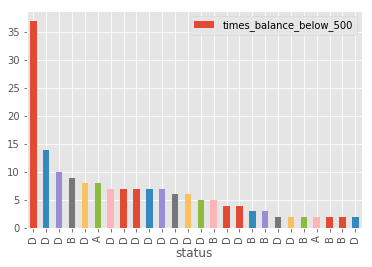

In [48]:
temp.sort_values("times_balance_below_500", ascending=False).plot(
    x="status", y="times_balance_below_500", kind="bar"
)

In [49]:
t = loan.loc[:, ["payments", "status"]]
t.head(3)

,payments,status
0,8033.0,B
1,4610.0,A
2,2118.0,A


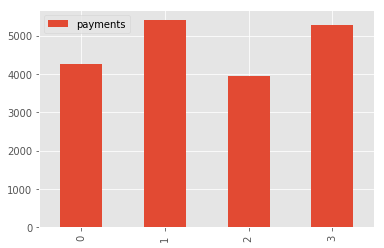

In [50]:
t = t.groupby(["status"], as_index=None).mean()
t.plot(kind="bar")

In [51]:
df = pd.merge(
    merge_loan_trans,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)

In [52]:
df = pd.merge(
    df,
    order,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_a", "_order"),
    copy=True,
    indicator=False,
    validate=None,
)

In [53]:
df = pd.merge(
    df,
    disp,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_b", "_disp"),
    copy=True,
    indicator=False,
    validate=None,
)

In [54]:
df = pd.merge(
    df,
    card,
    how="left",
    on="disp_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_c", "_card"),
    copy=True,
    indicator=False,
    validate=None,
)

In [55]:
df = pd.merge(
    df,
    client,
    how="left",
    on="client_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_d", "_client"),
    copy=True,
    indicator=False,
    validate=None,
)

In [56]:
df = pd.merge(
    df,
    district,
    how="left",
    left_on="district_id_client",
    right_on="A1",
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_e", "_district"),
    copy=True,
    indicator=False,
    validate=None,
)

In [57]:
before_loan_date = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
before_loan_date = before_loan_date.loc[:, ["account_id", "trans_id"]]
trans_pv_k_symbol = pd.merge(
    before_loan_date,
    trans_pv_k_symbol,
    how="left",
    on="trans_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_before", "_df2"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_pv_k_symbol.drop(
    ["account_id_df2", "date", "trans_id"], axis=1, inplace=True
)
trans_pv_k_symbol.rename(columns={"account_id_before": "account_id"}, inplace=True)
trans_pv_k_symbol = trans_pv_k_symbol.groupby(
    by="account_id", axis=0, as_index=False, sort=True, group_keys=True, squeeze=False
).mean()

In [58]:
df = pd.merge(
    df,
    trans_pv_k_symbol,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_df", "_tt"),
    copy=True,
    indicator=False,
    validate=None,
)

3. Data Cleaning

In [59]:
df["year_"] = df.date_loan.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_loan"] = 1999 - df.year_
df.drop(["date_loan", "year_"], axis=1, inplace=True)

In [60]:
df.frequency = df.frequency.map({"POPLATEK MESICNE": 30, "POPLATEK TYDNE": 7, "POPLATEK PO OBRATU": 1})

In [61]:
df["year_"] = df.date_account.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_account"] = 1999 - df.year_
df.drop(["date_account", "year_", "type_disp"], axis=1, inplace=True)

In [62]:
df.issued.fillna("999999", inplace=True)

In [63]:
df["years_card_issued"] = df.issued.apply(lambda x: pd.to_datetime(1999).year - pd.to_datetime(x).year if x != "999999" else 0,convert_dtype=int )

In [64]:
df.drop(["issued","A12","A15"], axis=1, inplace=True)
df.fillna(0, inplace=True)


In [65]:
df.status.value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 57 columns):
loan_id                         682 non-null int64
account_id                      682 non-null int64
amount                          682 non-null int64
duration                        682 non-null int64
payments                        682 non-null float64
status                          682 non-null object
avg_balance_3M_befroe_loan      682 non-null float64
avg_balance_1M_befroe_loan      682 non-null float64
trans_freq                      682 non-null int64
min_balance_befroe_loan         682 non-null float64
avg_amount_trans_before_loan    682 non-null float64
avg_balance_before_loan         682 non-null float64
times_balance_below_500         682 non-null float64
times_balance_below_5K          682 non-null float64
district_id_d                   682 non-null int64
frequency                       682 non-null int64
order_amount_LEASING            682 non-null float64
order_amo

#### GET Label

In [67]:
m = {"A": 0, "B": 1, "C": 0, "D": 1}
df.status = df.status.map(m)
df.status.unique()

array([1, 0], dtype=int64)

In [68]:
df = pd.get_dummies(df, drop_first=True)

In [69]:
df.columns.unique()

Index(['loan_id', 'account_id', 'amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'district_id_d', 'frequency',
       'order_amount_LEASING', 'order_amount_No_symbol',
       'order_amount_POJISTNE', 'order_amount_SIPO', 'order_amount_UVER',
       'disp_id', 'client_id', 'card_id', 'type', 'district_id_client', 'age',
       'sex', 'A1', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A13',
       'A14', 'A16', 'amount_POJISTNE', 'amount_SANKC. UROK', 'amount_SIPO',
       'amount_SLUZBY', 'amount_UROK', 'amount_UVER',
       'amount_k_symbol_missing', 'balance_POJISTNE', 'balance_SANKC. UROK',
       'balance_SIPO', 'balance_SLUZBY', 'balance_UROK', 'balance_UVER',
       'balance_k_symbol_missing', 'years_of_loan', 'years_of_account',
       'years

In [70]:
df.drop(
    [
        "loan_id",
        "account_id",
        "district_id_d",
        "disp_id",
        "client_id",
        "card_id",
        "district_id_client",
    ],
    axis=1,
    inplace=True,
)

#### DATA PROCESSING

In [71]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Draft Modeling: Random Forest

In [72]:
rf = ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [ ]:
fi = rf.feature_importances_

In [ ]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)

In [ ]:
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:20].plot(x="feature", y="importance", kind="bar")

Visualization & Feature Selection

In [ ]:
df.groupby(["sex", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.xlabel({"1": "male", "0": "female"})
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()

In [ ]:
df.groupby(["sex", "status"])["status"].size()


In [ ]:
df.groupby(["age", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="hist", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [ ]:
df.groupby(["times_balance_below_5K", "status"])["status"].size().groupby(
    level=0
).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()

In [ ]:
df.groupby(["years_card_issued", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.xlabel("years_visa_card_owned")
plt.legend(loc=1)
plt.show()

In [ ]:
df.hist(column="age", by="status", bins=20)
plt.xlabel("age")
plt.ylabel("count_of_loan_id")

In [ ]:
# Binning:
def binning(col, cut_points, labels=None):
    # Define min and max values:
    minval = col.min()
    maxval = col.max()

    # create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    # if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points) + 1)

    # Binning using cut function of pandas
    colBin = pd.cut(col, bins=break_points, labels=labels, include_lowest=True)
    return colBin


# Binning age:
cut_points = [24, 34, 44, 50]
labels = ["20", "25", "35", "45", "50"]
df["age_bin"] = binning(df["age"], cut_points, labels)


In [ ]:
df.groupby(["age_bin", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylabel("percentage - default or not")

In [ ]:
df[df.status == 1].head()

In [ ]:
a = loan.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
a.payments.mean().plot(kind="bar")
plt.ylabel("payments")

In [ ]:
# plot heatmap
import seaborn as sns

cols = list(importance.feature[:10])
cols.insert(0, "status")
corrcoef_map = np.corrcoef(df[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    corrcoef_map,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)

In [ ]:
df.groupby(by="status").size()

88.85% are good payers...11.14% falls to defaulters class

### Approach to handling Imbalanced Datasets

2.1 Data Level approach: Resampling Techniques

Dealing with imbalanced datasets entails strategies such as improving classification algorithms or balancing classes in the training data (data preprocessing) before providing the data as input to the machine learning algorithm. The later technique is preferred as it has wider application.

The main objective of balancing classes is to either increasing the frequency of the minority class or decreasing the frequency of the majority class. This is done in order to obtain approximately the same number of instances for both the classes. Let us look at a few resampling techniques:

2.1.1  Random Under-Sampling: Random Undersampling aims to balance class distribution by randomly eliminating majority class examples.  This is done until the majority and minority class instances are balanced out. We wont go for this as we have very less samples.

2.1.2  Random Over-Sampling
Over-Sampling increases the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample.

Advantages
    Unlike under sampling this method leads to no information loss.
    Outperforms under sampling
Disadvantages
    It increases the likelihood of overfitting since it replicates the minority class events.

2.1.3  Cluster-Based Over Sampling
In this case, the K-means clustering algorithm is independently applied to minority and majority class instances. This is to identify clusters in the dataset. Subsequently, each cluster is oversampled such that all clusters of the same class have an equal number of instances and all classes have the same size.  

Advantages
This clustering technique helps overcome the challenge between class imbalance. Where the number of examples representing positive class differs from the number of examples representing a negative class.
Also, overcome challenges within class imbalance, where a class is composed of different sub clusters. And each sub cluster does not contain the same number of examples.
Disadvantages
The main drawback of this algorithm, like most oversampling techniques is the possibility of over-fitting the training data

2.1.4  Informed Over Sampling: Synthetic Minority Over-sampling Technique

This technique is followed to avoid overfitting which occurs when exact replicas of minority instances are added to the main dataset. A subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These synthetic instances are then added to the original dataset. The new dataset is used as a sample to train the classification models.
Advantages
Mitigates the problem of overfitting caused by random oversampling as synthetic examples are generated rather than replication of instances
No loss of useful information
Disadvantages
While generating synthetic examples SMOTE does not take into consideration neighboring examples from other classes. This can result in increase in overlapping of classes and can introduce additional noise
SMOTE is not very effective for high dimensional data

2.1.5  Modified synthetic minority oversampling technique (MSMOTE)
It is a modified version of SMOTE. SMOTE does not consider the underlying distribution of the minority class and latent noises in the dataset. To improve the performance of SMOTE a modified method MSMOTE is used.

This algorithm classifies the samples of minority classes into 3 distinct groups – Security/Safe samples, Border samples, and latent nose samples. This is done by calculating the distances among samples of the minority class and samples of the training data.

Security samples are those data points which can improve the performance of a classifier. While on the other hand, noise are the data points which can reduce the performance of the classifier.  The ones which are difficult to categorize into any of the two are classified as border samples.

While the basic flow of MSOMTE is the same as that of SMOTE (discussed in the previous section).  In MSMOTE the strategy of selecting nearest neighbors is different from SMOTE. The algorithm randomly selects a data point from the k nearest neighbors for the security sample, selects the nearest neighbor from the border samples and does nothing for latent noise.

 

0    606
1     76
Name: status, dtype: int64

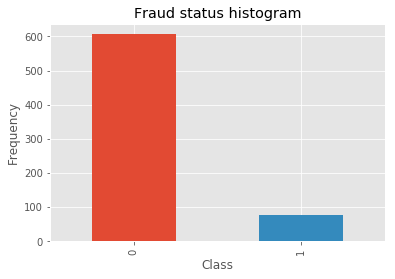

In [73]:
pd.value_counts(df['status']).plot.bar()
plt.title('Fraud status histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
df['status'].value_counts()

In [74]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (477, 49)
Number transactions y_train dataset:  (477,)
Number transactions X_test dataset:  (205, 49)
Number transactions y_test dataset:  (205,)


In [75]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 50
Before OverSampling, counts of label '0': 427 



In [76]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (854, 49)
After OverSampling, the shape of train_y: (854,) 

After OverSampling, counts of label '1': 427
After OverSampling, counts of label '0': 427


In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    6.3s finished
C:\Users\Gracy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [78]:
clf.best_params_

{'C': 1.0}

In [79]:
lr1 = LogisticRegression(C=4,penalty='l1', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

C:\Users\Gracy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

C:\Users\Gracy\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=5,
                   warm_start=False)

In [80]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 92.0%


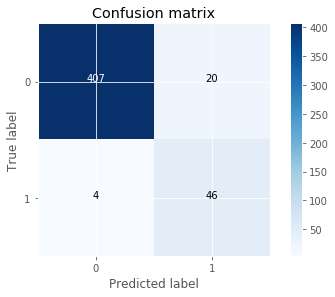

In [81]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 69.23076923076923%


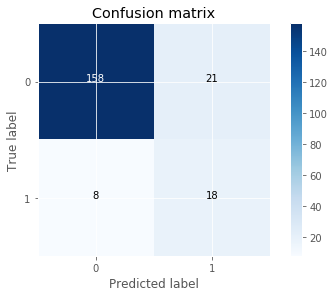

In [82]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [83]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())

C:\Users\Gracy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

C:\Users\Gracy\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


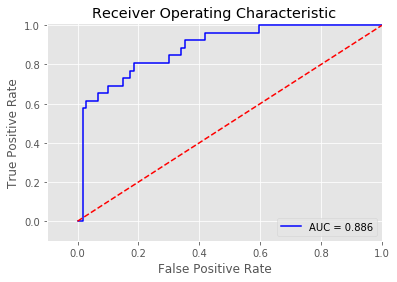

In [84]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Can Try the same with Gradientboost,XGBoost and AdaBoost

In [94]:
parameters = {
    'learning_rate': [0.01,0.1,0.9],
    'n_estimators' : [30,60,100],
     'max_depth': [2,3,4]
             }
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(loss="deviance",random_state=123)

In [95]:
clf = GridSearchCV(gbrt, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 126 tasks      | elapsed:   11.8s
[Parallel(n_jobs=3)]: Done 130 out of 135 | elapsed:   12.3s remaining:    0.4s
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:   12.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [96]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [98]:
gb = GradientBoostingClassifier(loss="deviance",random_state=123,learning_rate = 0.1, max_depth = 4 , n_estimators=100)

In [99]:
gb.fit(X_train_res, y_train_res.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Recall metric in the train dataset: 100.0%


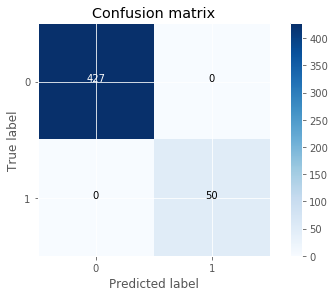

In [100]:
y_train_pre = gb.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 76.92307692307692%


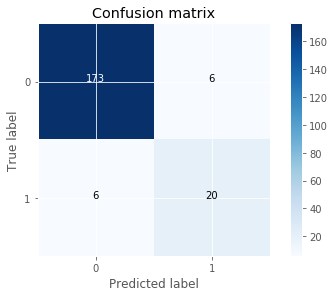

In [101]:
y_pre = gb.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

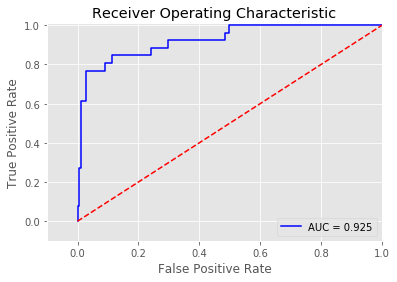

In [102]:
tmp = gb.fit(X_train_res, y_train_res.ravel())
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [105]:
parameters = {
    'learning_rate': [0.01,0.1,0.9],
    'n_estimators' : [30,60,100],
     'subsample' : [0.5,0.8,1.0],
     'max_depth': [2,3,4,5],
     'gamma' : [8,10,12]
             }
from xgboost import XGBClassifier
xgb =  XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      colsample_bytree = 0.4,
                      objective='binary:logistic', 
                      reg_alpha = 0.3)
clf = GridSearchCV(xgb, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   13.6s
[Parallel(n_jobs=3)]: Done 368 tasks      | elapsed:   27.7s
[Parallel(n_jobs=3)]: Done 692 tasks      | elapsed:   44.6s
[Parallel(n_jobs=3)]: Done 1088 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 1556 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 1620 out of 1620 | elapsed:  1.5min finished
C:\Users\Gracy\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 12 pruned nodes, max_depth=5
[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=5
[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 22 pruned nodes, max_depth=5
[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 18 pruned nodes, max_depth=4
[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=5
[17:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes,

[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 28 pruned nodes, max_depth=2
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=0.4,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0.3,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=False, subsample=1),
             iid='warn', n_jobs=3,
             param_grid={'gamma': [8, 10, 12],
                         'learning_rate': [0.01, 0.1, 0.9],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators'

In [106]:
clf.best_params_

{'gamma': 8,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.8}

In [107]:
xgb1 = XGBClassifier(silent=False, scale_pos_weight=1,colsample_bytree = 0.4,objective='binary:logistic', 
                      reg_alpha = 0.3,random_state=123,learning_rate = 0.1, max_depth = 5 , n_estimators=100,gamma = 8,subsample=0.8)
xgb1.fit(X_train_res, y_train_res.ravel())


[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=5
[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=5
[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=5
[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=5
[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=5
[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=5
[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=5
[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=5
[17:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 18 pruned nodes

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.4, gamma=8, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=123, reg_alpha=0.3,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
              subsample=0.8)

Recall metric in the train dataset: 95.78454332552693%


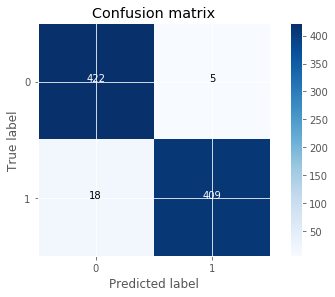

In [112]:
y_train_pre = xgb1.predict(X_train_res)

cnf_matrix_tra = confusion_matrix(y_train_res, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
y_pre = xgb1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [114]:


tmp = xgb1.fit(X_train_res, y_train_res.ravel())
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=5
[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 14 pruned nodes, max_depth=5
[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=5
[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=5
[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=5
[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=5
[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=5
[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=5
[18:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 18 pruned nodes

AttributeError: 'XGBClassifier' object has no attribute 'decision_function'